# Predicting the Success of Bank Telemarketing
## Project by Piotr Borowski & Katarzyna Kryńska

## Introduction




## Attribute Description

Input variables:
* bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
* related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
* social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: quarterly average of the total number of employed citizens (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/kasiakry/ml2-big-dataset/master/bank-additional-full.csv', sep=';')

In [3]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Cleaning the dataset

At first sight, it might seem that the dataset does not contain any missing values.

In [4]:
df.isna().values.any()

False

However, in case of nominal values, such as education or default, we can see that some rows contain 'unknown' value.

For nominal variables, there are a few ways of handling missing values:

1. Ignore observations with missing values - usually adequate when dataset is large and number of records with missing values is low and when missing data is not Missing not at Random (the most popular example is that people with high salaries generally do not want to reveal their income in surveys).
2. Ignore variable containing missing values - usually adequate if the variable is not significant.
3. Replace missing value with most frequent value - there is a risk that it will introduce bias.
4. Predict missing values - e.g. with multiclass predictor.
5. Treat missing data as another category.  

Firstly we will check which variables and how many rows contain 'unknown' value.

In [5]:
for col in df.columns.drop('y'):
    if df[col].dtype==object:
      percent_of_missing = df.loc[df[col]=='unknown',col].count() / len(df)
      if percent_of_missing > 0:
        print('Column', col, 'contains', '{:2.2%}'.format(percent_of_missing),'uknown values')

Column job contains 0.80% uknown values
Column marital contains 0.19% uknown values
Column education contains 4.20% uknown values
Column default contains 20.87% uknown values
Column housing contains 2.40% uknown values
Column loan contains 2.40% uknown values


We can see that variable *default* contains most missing data. We will plot a bar plot to check if this variable seems significant.

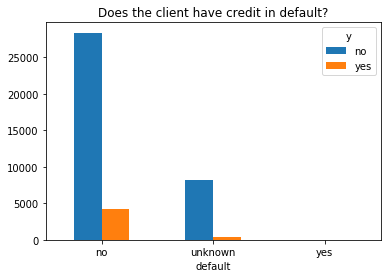

In [6]:
df.groupby('y')['default'].value_counts().unstack(0).plot.bar(rot=0, title='Does the client have credit in default?');

Bar plot suggests that it would be better to leave this variable as it is - with *uknown* values. We will also leave *uknown* values in other variables, with the exception of *marital* variable, as the number of missing data is very small - therefore we will use the most frequent value to replace missing values.

In [7]:
df['marital'] = df['marital'].replace('unknown', 'married')

### Duration

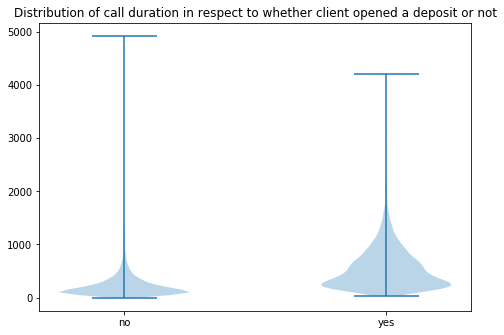

In [8]:
data_to_plot = [df.duration[df['y']=='no'].to_numpy(), df.duration[df['y']=='yes'].to_numpy()]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(data_to_plot)
ax.set_xticks(np.arange(1, 3))
ax.set_xticklabels(['no', 'yes'])
ax.set_title('Distribution of call duration in respect to whether client opened a deposit or not')
plt.show()

Variable "duration" is the duration of last call with the client. Including this variable as it is in our model could lead to a huge data leakage - for example if duration = 0 then y='no'. There seem to be two possible ways of coping with the problem. 

First one would be deleting observations with duration below a threshold, e.g. 30 seconds. However, from a business perspective, this solution is not ideal. Our goal is to make marketing strategies more effective - meaning consuming less of our resources. Clients who do not pick up phone, still are taking up our time to make a call to them. Secondly, duration of the call is not known before making the call - and ideally we would like to know client's propensity to our campaign before making the call.

Therefore, our decision is to remove 'duration' variable from our dataset.

In [9]:
df = df.drop("duration", axis=1)

### Exploratory data analysis

Firstly, we will check the number of clients that subscribed to a term deposit vs the number of clients that did not. We can see that the dataset is moderately imbalanced - number of clients that subscribed to a term deposit equals to 11.27% of the whole dataset. This means that accuracy might be not the best metric to measure performance of our classification models and also that it might be wise to use some techniques to work with imbalanced datasets, such as oversampling, undersampling or generating synthetic samples. 

Campaign overall success rate:  11.27%


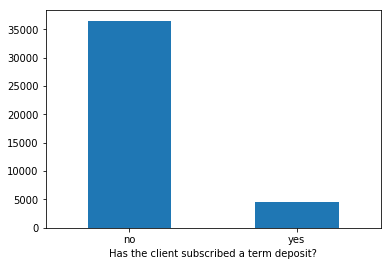

In [10]:
barplot = df['y'].value_counts().plot.bar(rot=0)
barplot.set_xlabel('Has the client subscribed a term deposit?');
print('Campaign overall success rate: ', '{:2.2%}'.format(len(df[df.y=='yes']) / len(df)))

Now we will look into distributions of numerical data in the dataset by plotting histograms. Firstly, we can see that in our dataset there is not many people in the age of 60+. Interestingly, we can divide our dataset in regard to Euribor rate into two groups - one with rate around 1% and the second one with rate from 4 to 5%. We can also notice that most of the dataset consists of clients who the company had not contacted before. 

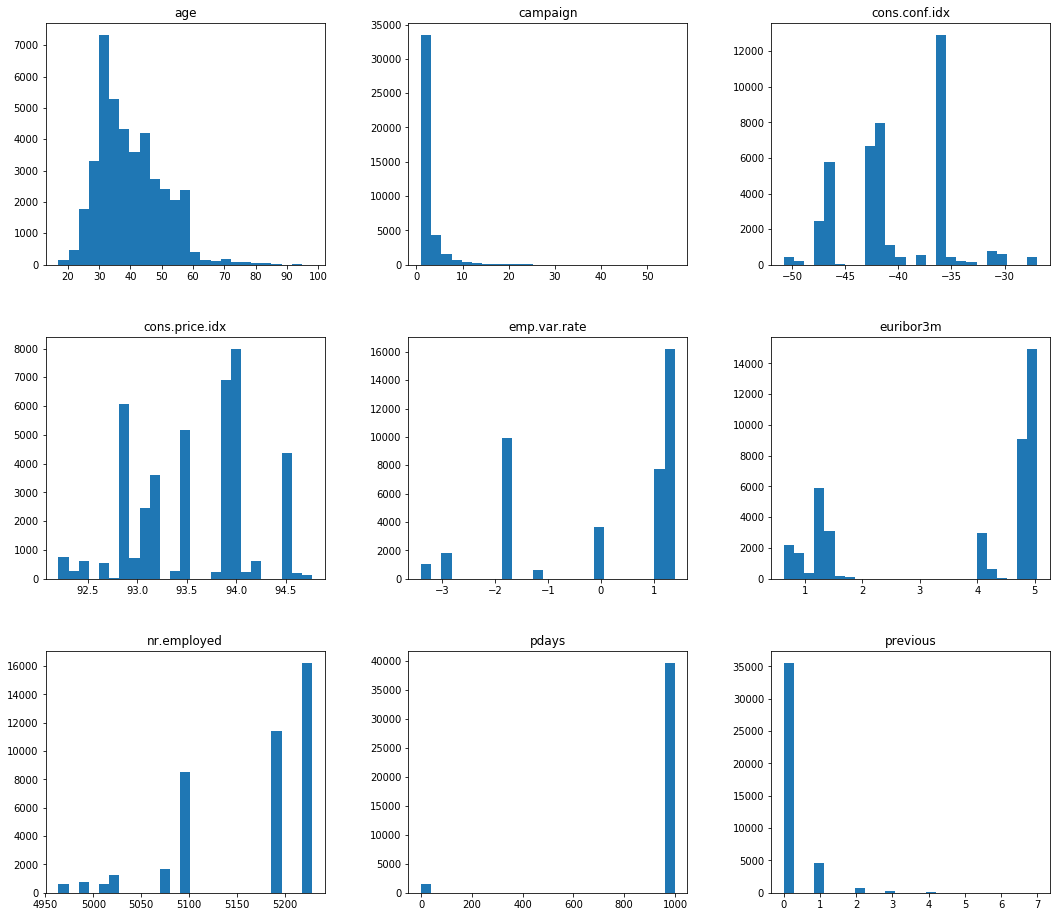

In [11]:
df.hist(figsize=(18,16), bins=25, grid=False);

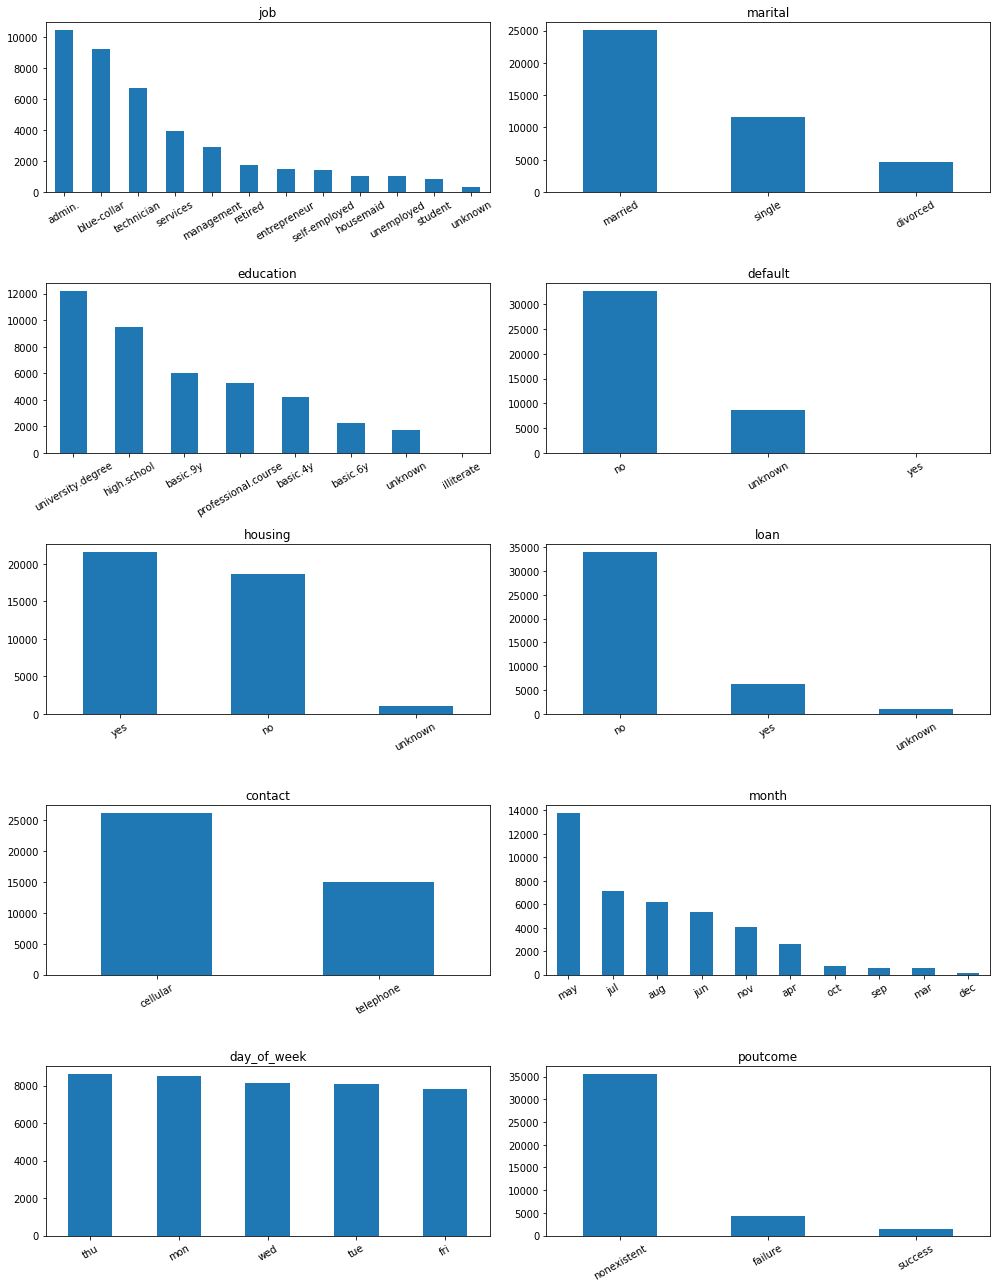

In [12]:
fig, axs = plt.subplots(5, 2)
i=0
for col in df.columns.drop('y'):
    if df[col].dtype==object:
        df[col].value_counts().plot.bar(rot=30, title=col, ax = axs[i//2,i%2])
        i=i+1
fig.set_size_inches(14, 18)
fig.tight_layout();

## Data preparation

Firstly, target variable needs to be recoded into binary form.

In [13]:
df["y"] = (df.y=="yes").astype(int)

Our dataset contains both continuous and discrete variables. Out of discrete variables, only one has potential to be treated as ordinal data - and that is education. However, due to 'uknown' values, we can not put all education categories in a particular order. Therefore, we will treat it as nominal variable. 

One Hot Encoding is known as "the classic approach" to dealing with nominal data. Accordingly, we will recode all variables with nominal levels to binary form.

In [14]:
levCols = []
numCols = []
for col in df.columns:
    if df[col].dtype==object:
        levCols.append(col)
    else:
        numCols.append(col)
dummLev = pd.get_dummies(df[levCols])
df_ohc = pd.concat([df[numCols], dummLev], axis=1)

In [15]:
df_ohc.head(10)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
5,45,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
6,59,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
7,41,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
8,24,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
9,25,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0


### Feature selection

#### ANOVA F-value For Feature Selection

In [16]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2

# Seperate the features from the target variable and choose only categorical variables
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

numCols.remove('y')

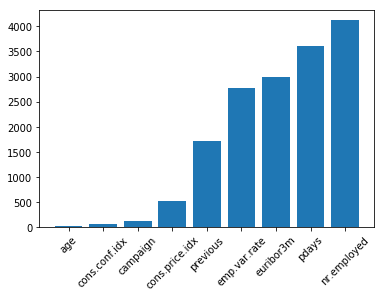

In [17]:
X_numerical = X[numCols]

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.3, random_state=58)

fs = SelectKBest(f_classif, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# plot the scores
labels = X_numerical.columns[np.argsort(fs.scores_)]
fs.scores_.sort()
fig1, ax = plt.subplots()
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks(np.arange(len(labels)),labels, rotation=45)
plt.show()

We can see that variable age does not seem very significant. Right now it is treated as a continous variable - before deleteing it, we will try changing it into nominal variable. Therefore we will create age categories: 15-25, 25-35, etc. up to 65+.

In [18]:
df['age_cat'] = np.zeros(len(df))
df.loc[df.age>15, 'age_cat'] = '1'
df.loc[df.age>25, 'age_cat'] = '2'
df.loc[df.age>35, 'age_cat'] = '3'
df.loc[df.age>45, 'age_cat'] = '4'
df.loc[df.age>55, 'age_cat'] = '5'
df.loc[df.age>65, 'age_cat'] = '6'
# one hot encoding - again
levCols = []
numCols = []
for col in df.columns:
    if df[col].dtype==object:
        levCols.append(col)
    else:
        numCols.append(col)
dummLev = pd.get_dummies(df[levCols])
df_ohc = pd.concat([df[numCols], dummLev], axis=1)

In [19]:
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

numCols.remove('y')

In [20]:
count = sum(map(lambda x : x > 200, fs.scores_))
bestfeatures  = SelectKBest(score_func=f_classif, k=count)
fit = bestfeatures.fit(X_train, y_train)
mask = bestfeatures.get_support()
cols_numerical = X_numerical.columns[mask]
print(cols_numerical)

Index(['pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')


Best numerical features are 'pdays', 'previous', 'emp.var.rate', cons.price.idx', 'euribor3m', 'nr.employed'.

#### Chi-Squared Feature Selection

For categorical variables, we will use chi-squared feature selection.

In [21]:
# Seperate the features from the target variable and choose only categorical variables
y = df_ohc.y
X = df_ohc.drop('y', axis=1)
X_categorical = X.drop(numCols, axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.3, random_state=58)

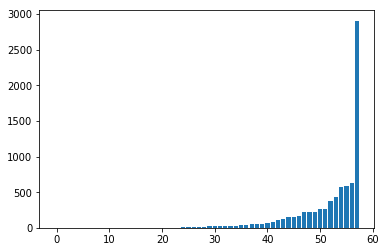

In [22]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# plot the scores
fs.scores_.sort()
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We decided to leave features for which score is above 5.

In [23]:
count = sum(map(lambda x : x > 5, fs.scores_))
bestfeatures  = SelectKBest(score_func=chi2, k=count)
fit = bestfeatures.fit(X_train, y_train)
mask = bestfeatures.get_support()
cols_categorical = X_categorical.columns[mask]
print(cols_categorical)

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_retired',
       'job_services', 'job_student', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_of_week_mon', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'age_cat_1', 'age_cat_3',
       'age_cat_4', 'age_cat_5', 'age_cat_6'],
      dtype='object')


In [24]:
df_feat = df_ohc[cols_numerical.to_list() + cols_categorical.to_list () + ['y']]
df_feat.head(5)

,pdays,previous,emp.var.rate,cons.price.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_retired,...,day_of_week_mon,poutcome_failure,poutcome_nonexistent,poutcome_success,age_cat_1,age_cat_3,age_cat_4,age_cat_5,age_cat_6,y
0,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
3,999,0,1.1,93.994,4.857,5191.0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
4,999,0,1.1,93.994,4.857,5191.0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0


In the end, our dataset contains 40 features.

## Performance Metrics

Because our data is imbalanced, using Accuracy can be misleading. In perspective of business needs, we need to have a small False Negative ratio (because these are the clients who would have be interested in making a deposit if we called them) and a high True Positive ratio. Therefore the metrics that we will be most interested in is Sensitivity (Recall).


![alt text](https://raw.githubusercontent.com/kasiakry/ml2-big-dataset/master/confusion_matrix.PNG)

To make plots, we will use function provided by [wagnerbhbr](https://github.com/wcipriano/pretty-print-confusion-matrix), slightly modified to suit our needs.



In [25]:
#import sys, importlib
#importlib.reload(sys.modules['confusion_matrix_pretty_print'])
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data
def plot_conf_m(y_train, y_train_pred, y_test, y_test_pred):
  fig, axs = plt.subplots(1, 2)
  plot_confusion_matrix_from_data(y_train, y_train_pred, figsize=[6,6], columns=['No','Yes'], pred_val_axis='y', ax1=axs[0], title='Training dataset')
  plot_confusion_matrix_from_data(y_test, y_test_pred, figsize=[6,6], columns=['No','Yes'], pred_val_axis='y', ax1=fig.axes[1], title='Testing dataset')
  fig.set_size_inches(12, 6)
  fig.tight_layout()
  fig.show();

## Logistic regression

Logistic regression is an excellent baseline algorithm and it can serve as a benchmark to our later models. Python library scikit-learn offers five different solvers algorithms - in our analysis we chose 'lbfgs', as it is usually faster for bigger datasets than 'liblinear' and it does not need scaling the features. We increased the maximum number of iterations to 1000, as the algorithm failed to converge with default 100 iterations. 

### Logistic regression on full dataset

In [31]:
# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Train model
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

# Predict on training dataset
y_train_pred_lr = log_reg.predict(X_train)

# Predict on testing dataset
y_pred_lr = log_reg.predict(X_test)

C:\Users\xx\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


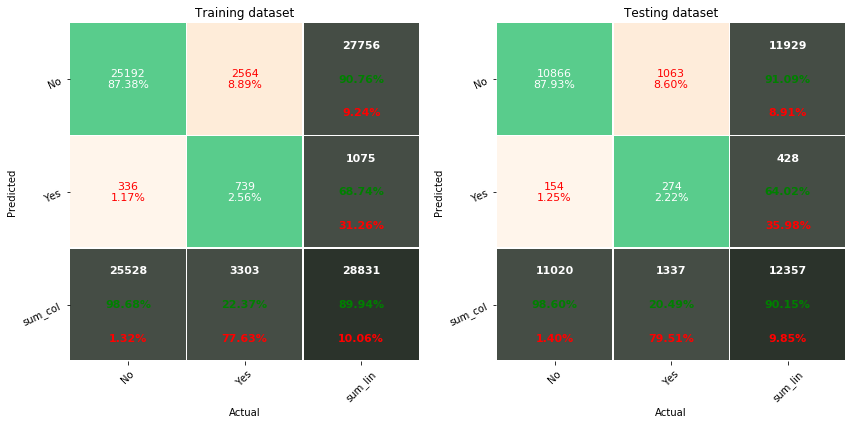

In [32]:
plot_conf_m(y_train, y_train_pred_lr,y_test, y_pred_lr)

Recall on testing dataset is **20.49%**. 

### Logistic regression on feature-selected dataset 

C:\Users\xx\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


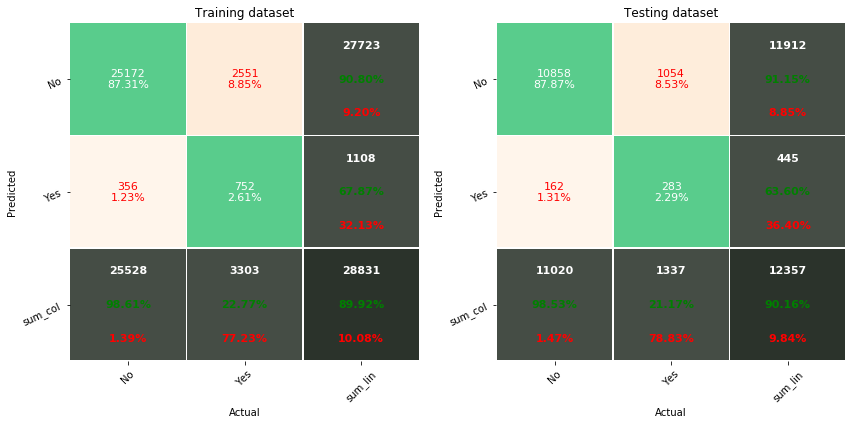

In [33]:
# Seperate the features from the target variable
y = df_feat.y
X = df_feat.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Train model
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, y_train)

# Predict on training dataset
y_train_pred_lr = log_reg.predict(X_train)

# Predict on testing dataset
y_pred_lr = log_reg.predict(X_test)

plot_conf_m(y_train, y_train_pred_lr,y_test, y_pred_lr)

We can see that logistic regression on our feature-selected dataset is slightly better - recall on test dataset equals to **21.17%**. 

## Decision tree

Decision trees are a non-parametric supervised learning method. They are simple to understand and interpret and, what more, they are easy to visualize. Decision trees frequently perform well on imbalanced data. However, they are prone to overfitting - to avoid this problem we can use following solutions:
1. Pre-pruning by setting appropriate stopping criterion,
2. Post-pruning the large tree.

Python library scikit learn provides parameters *min_samples_leaf*, *max_depth* to prevent a tree from overfitting. It also provides cost complexity parameter parameter *alpha*, which is used in a pruning technique called cost complexity pruning. In our project, we will use this technique. To set adequate alpha, we will divide our training dataset into training and validation samples and apply best performing tree to our test data.

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

# Divide train dataset into training and validation subsets
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, random_state=58)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=58)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))


Number of nodes in the last tree is: 3 with ccp_alpha: 0.030137787434358354


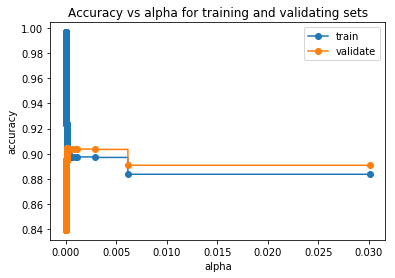

In [33]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
validate_scores = [clf.score(X_validate, y_validate) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validating sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, validate_scores, marker='o', label="validate",
        drawstyle="steps-post")
ax.legend()
plt.show()

We can see that when alpha is set to 0, tree overfits, resulting in 100% accuracy for train and only 84% for validate set. Alpha that maximizes accuracy is somewhere around 0.003.

In [38]:
clf = DecisionTreeClassifier(random_state=58, ccp_alpha=0.003)

# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

clf.fit(X_train, y_train)

# Predict on training dataset
y_train_pred_dt = clf.predict(X_train)

# Predict on testing dataset
y_pred_dt = clf.predict(X_test)

C:\Users\xx\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


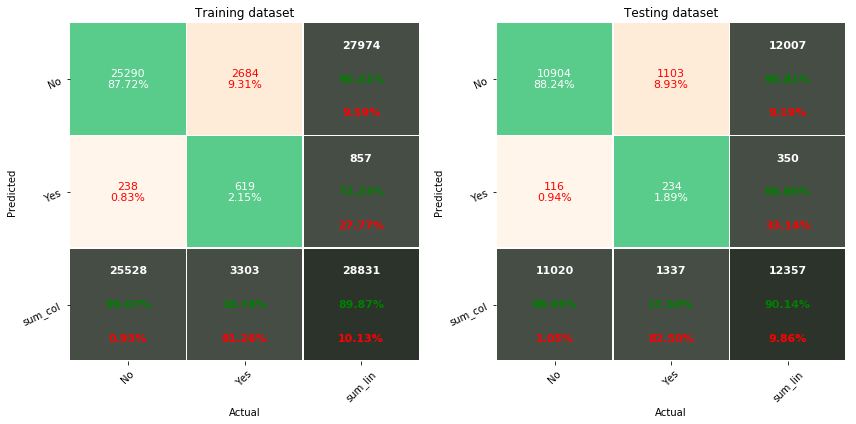

In [35]:
plot_conf_m(y_train, y_train_pred_dt,y_test, y_pred_dt)

Unfortunately, decision tree on testing dataset achieves only **17.50%** recall score.

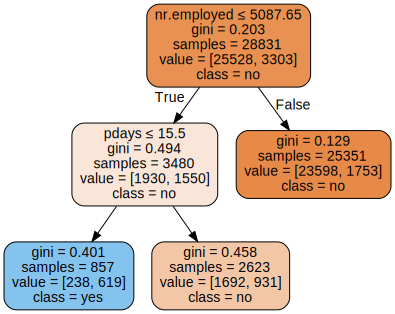

In [36]:
from sklearn import tree
import graphviz 
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_train.columns,
                                class_names=['no','yes'],
                                filled=True, rounded=True,
                                special_characters=True) 
graph = graphviz.Source(dot_data)
graph

Decision tree classifies true if the number of employees is less than 5087.65 and number of days since last contact is less than 15.5.

## Random Forest

Random decision forests are an ensemble learning method for classification. They operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes. Therefore we expect that they will have better prediction power than simple decision tree. To implement Random Forest, we will use python package sk-learn.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Random Forests are robust to over-fittng effect, thus we will perform Random Forest on whole dataset - not the feature-selected one.

In [27]:
rf = RandomForestClassifier(random_state=58)

# Seperate the features from the target variable
y = df_ohc.y
X = df_ohc.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

To tune up the parameters, we will use Hyperparameter Tuning. We will firstly create a Random Hyperparameter Grid and then randomly sample from the grid, performing K-Fold CV with Scikit-Learn's RandomizedSearchCV method.

In [39]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=58, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 57.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

We can view the best parameters from fitting the random search:

In [41]:
print(rf_random.best_params_)

{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


With random search, we narrowed down the range for each hyperparameter. Now we will do GridSearchCV which evaluates not randomply sampled combinations but all combinations.

In [35]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5, 7],
    'min_samples_split': [2, 3],
    'n_estimators': [1500, 1600, 1700]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)

In [36]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 1500}

We can see that 2 parameters were boundaries of the grid, so to be sure they're the optimal parameters, we will do Grid Search once again, just for these 2 parameters.

In [44]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10],
    'max_features': ['auto'],
    'min_samples_leaf': [4],
    'min_samples_split': [3,4,5,6],
    'n_estimators': [1400,1500,1600]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  3.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  3.4min remaining:   48.9s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  3.9min remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.0min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 1600}

Finally, we can make predictions using best parameters.

C:\Users\xx\Anaconda3\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


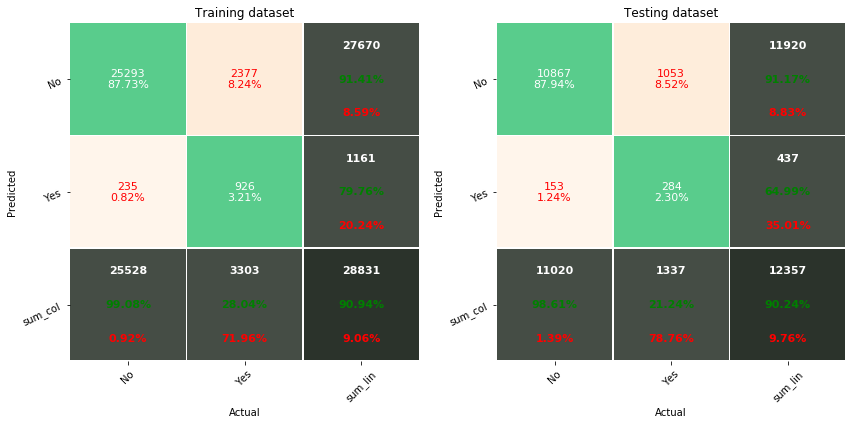

In [47]:
# Predict on training dataset
y_train_pred_gsrf = grid_search.predict(X_train)

# Predict on testing dataset
y_pred_gsrf = grid_search.predict(X_test)

plot_conf_m(y_train, y_train_pred_gsrf,y_test, y_pred_gsrf)

We can see that random forest has **21.24%** recall score, which is much better than decision tree.

## XGBoost

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy.

XGBoost is well known to provide better solutions than other machine learning algorithms and we expect it to have much better recall score than previously used methods.

In [60]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [67]:
def my_xgboost_fit(xgb1, X_train, y_train, cv_folds=5, early_stopping_rounds=50):
    xgb_param = xgb1.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=cv_folds,
            metrics='aucpr', early_stopping_rounds=early_stopping_rounds, seed=58)
    xgb1.set_params(n_estimators=cvresult.shape[0])
    
     #Fit the algorithm on the data
    xgb1.fit(X_train, y_train, eval_metric='aucpr')
    
    # Predict on testing dataset
    y_pred_xgb1 = xgb1.predict(X_train)
    
    print("Accuracy (Train): %.4g" % accuracy_score(y_train, y_pred_xgb1))
    print("Recall Score (Train): %f" % recall_score(y_train, y_pred_xgb1))

In [49]:
# Seperate the features from the target variable
y = df_feat.y
X = df_feat.drop('y', axis=1)

# Divide dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=58)

We will set objective to reg:logistic as it's classification problems with only decision, colsample_bytree (percentage of features used per tree) to 0.8 (but we keep in mind that high values can lead to overfitting), learning rate (step size shrinkage used to prevent overfitting) to 0.1, max depth of tree to 10, gamma to 0 and number of trees we want to build to 100.

In [71]:
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=10, min_child_weight=1,
 gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:logistic', nthread=4, scale_pos_weight=1, seed=58)

my_xgboost_fit(xgb1, X_train, y_train)

Accuracy (Train): 0.9145
Recall Score (Train): 0.348168


Now we will perform hyperparameter boosting. Our evaluation metrics will be the area under the curve of Precision-Recall curve to get the best Recall score. In contrast to parameter tuning for Random Forests, here we will look for best parameters one by one instead of doing random search.

In [72]:
param_test1 = {
 'max_depth':range(3,15,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=10,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:logistic', nthread=4, scale_pos_weight=1, seed=58), 
 param_grid = param_test1, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  4.3min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.3min finished
C:\Users\xx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 13, 'min_child_weight': 1}, 0.3024558749369642)

Now we will try parameters around 13 for max_depth and 1 for min_child_weight to be sure that we have the optimal ones.

In [73]:
param_test2 = {
 'max_depth':[12,13,14],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=13,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:logistic', nthread=4, scale_pos_weight=1, seed=58), 
 param_grid = param_test2, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:  3.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:  4.3min remaining:   31.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.5min finished
C:\Users\xx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 14, 'min_child_weight': 1}, 0.307296566267822)

In [74]:
param_test2b = {
 'max_depth':[14,15,16]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=100, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:logistic', nthread=4, scale_pos_weight=1,seed=58), 
 param_grid = param_test2b, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)
gsearch2b.fit(X_train,y_train)
gsearch2b.best_params_, gsearch2b.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   39.5s remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   40.0s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   41.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   44.3s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.5min remaining:   44.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.5min remaining:   23.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished
C:\Users\xx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 14}, 0.3088112593407601)

It seems that the optimal max_depth is 14. Now we will tune gamma.

In [78]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,50,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:logistic', nthread=4, scale_pos_weight=1,seed=58), 
 param_grid = param_test3, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.4min remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.7min remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished
C:\Users\xx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.0}, 0.3088112593407601)

The best gamma value seems to be our initial value, 0.

In [102]:
xgb2 = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=14, min_child_weight=1, gamma=0,
 subsample=0.8, colsample_bytree=0.8, objective= 'reg:logistic', nthread=-1, scale_pos_weight=1,
 seed=58, verbose = 10)
my_xgboost_fit(xgb2, X_train, y_train)

C:\Users\xx\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Accuracy (Train): 0.9197
Recall Score (Train): 0.385104


The next step is to try different subsample and colsample_bytree parameters.

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=150, max_depth=14,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:logistic', nthread=-1, scale_pos_weight=1,seed=58), 
 param_grid = param_test4, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)

gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.2min


In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=58), 
 param_grid = param_test5, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)

gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

After that, we will apply regulazation to reduce overfitting. 

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'reg_lambda':[0,0.5,1,1.5,2]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
 min_child_weight=5, gamma=0, subsample=0.85, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=58), 
 param_grid = param_test6, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)

gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'reg_alpha':[0, 0.00001, 0.00005],
 'reg_lambda':[2,3,4]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
 min_child_weight=5, gamma=0, subsample=0.85, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=58), 
 param_grid = param_test7, scoring='recall',n_jobs=-1,iid=False, cv=5, verbose = 10)
gsearch7.fit(X_train,y_train)
gsearch7.best_params_, gsearch7.best_score_

In [ ]:
xgb3 = XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=12, min_child_weight=5, gamma=0,
 subsample=0.85, colsample_bytree=0.8, objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,
 seed=58, verbose = 10,reg_alpha=5e-05,reg_lambda=2)
my_xgboost_fit(xgb3, X_train, y_train)

In [ ]:
Reducing Learning Rate

In [ ]:
xgb4 = XGBClassifier( learning_rate =0.05, n_estimators=5000, max_depth=12, min_child_weight=5, gamma=0,
 subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=-1, scale_pos_weight=1,
 seed=58, verbose = 10,reg_alpha=5e-05,reg_lambda=2)
my_xgboost_fit(xgb4, X_train, y_train)

In [ ]:
# Predict on training dataset
y_train_pred_xgb = xgb4.predict(X_train)

# Predict on testing dataset
y_pred_xgb = xgb4.predict(X_test)

plot_conf_m(y_train, y_train_pred_xgb,y_test, y_pred_xgb)

In [ ]:
accuracy = [0.9061, 0.9083, 0.9089]
recall = [0.284590, 0.315471, 0.316985]
x = [1,2,3]

fig, ax1 = plt.subplots()
#plt.plot(x, accuracy, marker='o', linestyle='dashed', label='accuracy')
#plt.plot(x, recall, marker='o', linestyle='dashed', label='recall')

color = 'tab:orange'
ax1.set_xlabel('step')
ax1.set_ylabel('', color=color)
ax1.plot(x, accuracy, color=color, marker='o', linestyle='dashed', label='accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('', color=color)  # we already handled the x-label with ax1
ax2.plot(x, recall, color=color, marker='o', linestyle='dashed', label='recall')
ax2.tick_params(axis='y', labelcolor=color)
fig.legend()

plt.xticks(np.arange(1, 4, step=1))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
accuracy = [90.01, 90.14, 90.29, 90.36]
recall = [20.57, 17.50, 23.41, 26.40]
x = [1,2,3,4]

fig, ax1 = plt.subplots()
#plt.plot(x, accuracy, marker='o', linestyle='dashed', label='accuracy')
#plt.plot(x, recall, marker='o', linestyle='dashed', label='recall')

color = 'tab:orange'
ax1.set_xlabel('')
ax1.set_ylabel('', color=color)
ax1.plot(x, accuracy, color=color, marker='o', linestyle='dashed', label='accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('', color=color)  # we already handled the x-label with ax1
ax2.plot(x, recall, color=color, marker='o', linestyle='dashed', label='recall')
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc='upper center')

plt.xticks(x,["Logistic Regression", "Decision tree", "Random Forest", "XGBoost"])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
y_train_pred_lr
y_train_pred_dt


In [ ]:
y_pred_lr
y_pred_dt
